<a href="https://colab.research.google.com/github/mforbs/FCCCatDogClassifier/blob/main/CatDogClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [3]:
# 3

# These are just loading the images to matrices, and scaling each value (rgb) down to 0-1
train_image_generator = ImageDataGenerator(
    rescale=1./255,
)
validation_image_generator = ImageDataGenerator(
    rescale=1./255,
)
test_image_generator = ImageDataGenerator(
    rescale=1./255,
)

# Load the data with class mode binary, since it's either a dog or not (in which case it's a cat)
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)
val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# No classes on test data, the classes are provided below
test_data_gen = test_image_generator.flow_from_directory(
    directory=PATH,
    classes = ['test'],
    batch_size=batch_size,
    color_mode='rgb',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False,
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


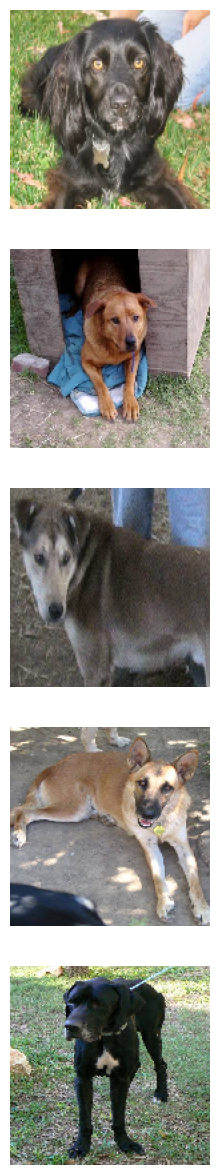

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [47]:
# 5
# This is the same training images, but this time, we can randomise alterations to the images. Serves to 'stretch' our training data set, by using slightly different images each time.
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    zoom_range=.1,
    shear_range=.1,
    horizontal_flip=True
)


Found 2000 images belonging to 2 classes.


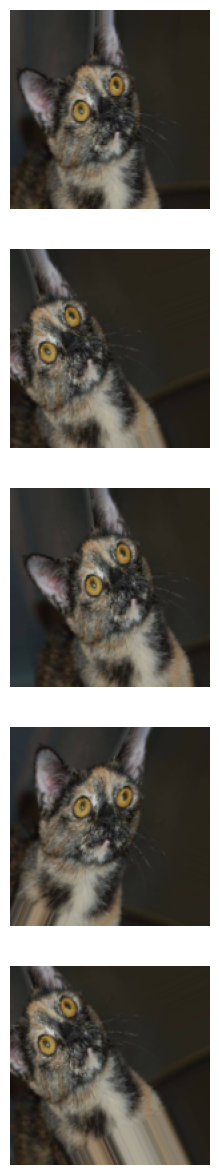

In [6]:
# 6
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [44]:
# 7
class_names = ['cat', 'dog']

# Some research (googling) showed that subsequent Conv2D layers usually use more and more features throughout the layers, so here I double each time.

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # One output using sigmoid for probability

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,207,457 (4.61 MB)

 Trainable params: 1,207,457 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# 8
model.compile(
    loss= 'binary_crossentropy', # Perfect for our binary case
    optimizer='adam', # TODO: Look more into the different optimisers and their purposes
    metrics=['accuracy']
)

history = model.fit(
    train_data_gen,
    steps_per_epoch= total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps= total_val // batch_size)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5709 - loss: 0.6741 - val_accuracy: 0.6083 - val_loss: 0.6676
Epoch 2/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6172 - loss: 0.6783

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.6172 - loss: 0.6783 - val_accuracy: 0.5982 - val_loss: 0.6709
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6157 - loss: 0.6712 - val_accuracy: 0.6339 - val_loss: 0.6499
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.6172 - loss: 0.6483 - val_accuracy: 0.6384 - val_loss: 0.6509
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 957ms/step - accuracy: 0.6169 - loss: 0.6531 - val_accuracy: 0.6618 - val_loss: 0.6303
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.6125 - loss: 0.6673 - val_accuracy: 0.6607 - val_loss: 0.6281
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6327 - loss: 0.6475 - val_accuracy: 0.6429 - val_loss: 0.6212
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7031 - loss: 0.5712 - val_accuracy: 0.6585 - val_loss: 0.6212
Epoch 9/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6515 - loss: 0.6416 - val_accuracy: 0.6763 - val_loss:

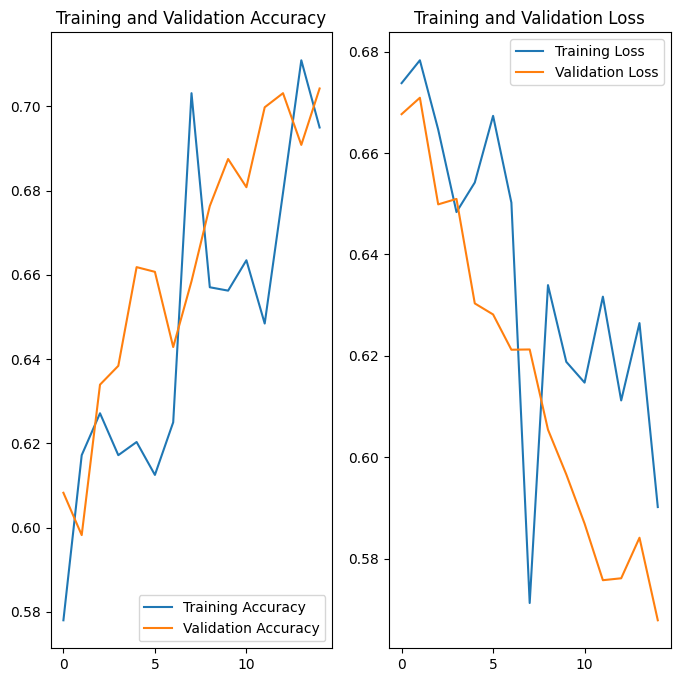

In [49]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
#10
probabilities = model.predict(test_data_gen)
probabilities = probabilities[:, 0] # Outputs n x 1 array, so just pluck each value to make 1d array
print(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
[0.45770237 0.16501111 0.1627002  0.5817778  0.42823124 0.31341136
 0.46855932 0.19994614 0.26101255 0.84792215 0.35375986 0.44058463
 0.2512943  0.07416943 0.3614731  0.7305088  0.6039082  0.8066243
 0.49926984 0.5231081  0.16427231 0.37092617 0.2967383  0.5159856
 0.38619515 0.32805982 0.93948764 0.27092806 0.2867216  0.4881295
 0.3113847  0.2357079  0.7594834  0.99674404 0.30564266 0.6086239
 0.960073   0.66301984 0.32277286 0.2970991  0.3225916  0.3879177
 0.75169957 0.5048069  0.31344095 0.2488529  0.2707256  0.28626874
 0.14652318 0.285423  ]


In [54]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 78.0% of the images of cats and dogs.
You passed the challenge!
